<a href="https://colab.research.google.com/github/KunAn89/Modeling_Risk/blob/main/Modeling_Market_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VaR
Value at Risk

https://colab.research.google.com/drive/12qNFYhKl5MuoDqGu9iyzRDUTbv5rqAIY?usp=sharing

Colab Running Information

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Package

In [ ]:
!pip install arch
!pip install deap
!pip install scikit-optimize
!pip install copulas

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx

from scipy.optimize import minimize
from scipy.stats import t
from scipy.stats import norm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input, Dense, LSTM, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from deap import base, creator, tools, algorithms

from skopt import BayesSearchCV

from copulas.multivariate import GaussianMultivariate

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from scipy.stats import norm, t

from arch import arch_model

from google.colab import auth
from google.auth import default

Data Reading

In [ ]:
#Setup for Google Sheets API
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
def get_sheet_data(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df['Date'] = df['Date'].str.split().str[0]
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.date
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    return df

In [ ]:
sheet_names = ["META", "MSFT", "NFLX"]

dataframes = [get_sheet_data(name) for name in sheet_names]

combined_df = pd.concat(dataframes, ignore_index=True)

for df in dataframes:
    print(df.head())

Test Data

In [ ]:
sheet_names_test = ["Test Data", "Test Data1", "Test Data2"]

dataframes_test = [get_sheet_data(name) for name in sheet_names_test]

combined_df = pd.concat(dataframes_test, ignore_index=True)

for df in dataframes_test:
    print(df.head())

Visulization

In [ ]:
dataframes_forSeen = {name: get_sheet_data(name) for name in sheet_names}
plt.figure(figsize=(12, 6))
for name, df in dataframes_forSeen.items():
    plt.plot(df['Date'], df['Close'], label=name)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Closing Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Data Set Reinforcement

Bootstraping

In [ ]:
def bootstrap_data(df, n_bootstraps=1):
    bootstrap_samples = []
    for _ in range(n_bootstraps):
        sample = df.sample(n=len(df), replace=True)  # Allow Repeat
        bootstrap_samples.append(sample)
    return bootstrap_samples

In [ ]:
# Assuming 'dataframes' is your list of original dataframes
bootstraped_dataframes = [bootstrap_data(df) for df in dataframes]

# Iterating through each bootstrap sample for each original dataframe
for i, bootstrapped_dfs in enumerate(bootstraped_dataframes):
    print(f"Original DataFrame {i}:")
    for j, df_sample in enumerate(bootstrapped_dfs):
        print(f"Bootstrap Sample {j + 1} Head:")
        print(df_sample.head())
        print()

LSTM

In [ ]:
def prepare_data_for_lstm(df, feature_columns, target_column, n_steps):

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[feature_columns])

    X, y = [], []

    # Create sequences
    for i in range(n_steps, len(df)):
        X.append(scaled_data[i-n_steps:i, :])
        y.append(scaled_data[i, df.columns.get_loc(target_column)])

    # Convert to arrays and reshape for LSTM
    X, y = np.array(X), np.array(y)

    # LSTM expects input shape of [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], len(feature_columns)))

    return X, y, scaler

In [ ]:
n_steps = 5  # Use data from the past 5 time points to predict the next time point

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
lstm_models = []
predictions = []

for df in dataframes:
    X, y, scaler = prepare_data_for_lstm(df=dataframes[0], feature_columns=['Open', 'High', 'Low', 'Close', 'Volume'], target_column='Close', n_steps=n_steps)
    model = build_lstm_model(X.shape[1:])
    model.fit(X, y, epochs=10, batch_size=32)
    lstm_models.append(model)
    predictions.append(model.predict(X))

GANS

In [ ]:
def build_generator(seq_length, latent_dim, n_features=5):
    input_noise = Input(shape=(latent_dim,))
    x = Dense(128)(input_noise)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(seq_length * n_features)(x)  # Adjust the number of units
    x = Reshape((seq_length, n_features))(x)  # Reshape to match the discriminator's input
    return Model(input_noise, x)

In [ ]:
def build_gan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    fake_seq = generator(z)
    discriminator.trainable = False
    validity = discriminator(fake_seq)
    return Model(z, validity)

In [ ]:
def build_discriminator(seq_length, n_features=5):
    seq = Input(shape=(seq_length, n_features))
    x = LSTM(64, return_sequences=True)(seq)
    x = LSTM(64)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(seq, x)

In [ ]:
# Function to preprocess and create sequences
def preprocess_and_create_sequences(df, selected_columns, seq_length):
    data = df[selected_columns]

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    X, y = create_sequences(scaled_data, seq_length)
    return X, y, scaler

# Preprocess each DataFrame and create sequences
latent_dim = 32
seq_length = 60
processed_data = [preprocess_and_create_sequences(df, ['Open', 'High', 'Low', 'Close', 'Volume'], seq_length) for df in dataframes]

In [ ]:
generator = build_generator(seq_length, latent_dim, n_features=5)  # Make sure to match n_features
discriminator = build_discriminator(seq_length, n_features=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [ ]:
def train_gan(generator, discriminator, gan, processed_data, epochs, batch_size, latent_dim):
    for data_tuple in processed_data:
        X, y, _ = data_tuple  # Assuming each tuple is (X, y, scaler)
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Randomly select real sequences
            idx = np.random.randint(0, X.shape[0], batch_size)
            real_seqs = X[idx]

            # Generate fake sequences
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_seqs = generator.predict(noise)

            # Train discriminator
            d_loss_real = discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = discriminator.train_on_batch(fake_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real)

            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

In [ ]:
train_gan(generator, discriminator, gan, processed_data, epochs=3, batch_size=32, latent_dim=latent_dim)

Stat Method

In [ ]:
def calculate_var(df, confidence_level=95):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate VaR at the specified confidence level
    var = np.percentile(df['Return'].dropna(), 100 - confidence_level)
    return var

In [ ]:
# Calculating VaR for each stock
for name, df in zip(sheet_names, dataframes):
    var = calculate_var(df)
    print(f"VaR at 95% confidence level for {name}: {var*100:.2f}%")

Historical Historical Maximum Loss

In [ ]:
# Function to calculate VaR by finding the greatest loss
def calculate_VaR_simple_loss(df):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Find the greatest loss (minimum return)
    greatest_loss = df['Return'].min()
    return greatest_loss

In [ ]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_simple_loss(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

Time Decay Factor EWMA

In [ ]:
def calculate_VaR_with_time_decay(df, decay_factor=1):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Apply exponential weighting
    weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
    weighted_returns = df['Return'] * weights
    weighted_returns /= weights.sum()

    # Find the greatest loss (minimum return) in weighted returns
    greatest_loss = weighted_returns.min()
    return greatest_loss

In [ ]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_with_time_decay(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

In [ ]:
def calculate_VaR_with_time_decay_amend(df, decay_factor=1):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Handle NaN values in returns
    df.dropna(subset=['Return'], inplace=True)

    # When decay_factor is 1, use unweighted returns directly
    if decay_factor == 1:
        greatest_loss = df['Return'].min()
    else:
        # Apply exponential weighting
        weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
        weighted_returns = df['Return'] * weights
        weighted_returns /= weights.sum()

        # Find the greatest loss in weighted returns
        greatest_loss = weighted_returns.min()

    return greatest_loss


In [ ]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_with_time_decay_amend(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

CVaR  Expected Shortfall (ES) Tail VaR

In [ ]:
def calculate_CVaR_with_time_decay(df, decay_factor=1, confidence_level=0.95):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Apply exponential weighting
    weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
    weighted_returns = df['Return'] * weights
    weighted_returns /= weights.sum()

    # Find the VaR (Value at Risk)
    VaR_threshold = np.percentile(weighted_returns.dropna(), (1 - confidence_level) * 100)

    # Calculate CVaR (Conditional Value at Risk)
    # Only consider the returns that are less than the VaR threshold
    tail_losses = weighted_returns[weighted_returns < VaR_threshold]
    CVaR = tail_losses.mean()  # Conditional VaR is the mean of the losses beyond the VaR threshold

    return CVaR

In [ ]:
# Calculating CVaR for each stock by identifying the conditional mean loss beyond the VaR threshold
for name, df in zip(sheet_names, dataframes):
    cvar = calculate_CVaR_with_time_decay(df)
    print(f"CVaR (conditional mean loss) for {name}: {cvar*100:.2f}%")

Monte Carlo

Individual Stock

In [ ]:
def calculate_stock_returns(initial_value, final_value, days=365):
    """
    Calculate the annual and daily returns of a stock.

    :param initial_value: The initial value of the stock.
    :param final_value: The final value of the stock after a period.
    :param days: The number of days over which the final value is measured. Default is 365 for one year.
    :return: A tuple containing the annual return and daily return as percentages.
    """
    # Calculate annual return
    annual_return = ((final_value - initial_value) / initial_value) * 100

    # Calculate daily return based on the number of days
    daily_return = ((final_value / initial_value) ** (1/days) - 1) * 100

    return annual_return, daily_return

Calculate return

In [ ]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:

        df['Date'] = pd.to_datetime(df['Date'])
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

        initial_value = df['Close'].iloc[0]
        final_value = df['Close'].iloc[-1]

        days = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days

        annual_return, daily_return = calculate_stock_returns(initial_value, final_value, days)

        print(name, f"Annual Return: {annual_return:.2f}%, Daily Return: {daily_return:.4f}%")

Normal Distribution

In [ ]:
def calculate_VaR_MonteCarlo_Normal(df, days=252, iterations=10000, confidence_level=0.95, plot=False, plot_paths=False):
    # Calculate daily returns
    returns = df['Close'].pct_change().dropna()

    # Fit a GARCH model to estimate volatility
    garch = arch_model(returns, vol='Garch', p=1, q=1)
    model = garch.fit(disp='off')
    forecast = model.forecast(horizon=days)
    vol = np.sqrt(forecast.variance.iloc[-1])

    # Calculate mean return
    mean_return = returns.mean()
    # Simulate returns using the normal distribution
    simulated_returns = np.random.normal(mean_return, vol, (iterations, days))
    # Calculate simulated price changes
    simulated_price_changes = np.exp(simulated_returns) - 1

    # Calculate VaR
    VaR = np.percentile(simulated_price_changes, (1 - confidence_level) * 100)

    if plot:
      # Flatten the array to make it one-dimensional
      flattened_simulated_changes = simulated_price_changes.flatten()
      plt.figure(figsize=(10, 6))
      plt.hist(flattened_simulated_changes, bins=50, alpha=0.7, color='red')
      plt.axvline(x=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR*100:.2f}%")
      plt.title(f"Simulated Price Changes Distribution\nVaR (at {confidence_level*100}%): {VaR*100:.2f}%")
      plt.xlabel('Simulated Price Changes')
      plt.ylabel('Frequency')
      plt.legend()
      plt.grid(True)
      plt.show()

    if plot_paths:
        vol = np.sqrt(forecast.variance.dropna().mean(axis=0))
        simulated_paths = np.zeros((iterations, days))

        for i in range(iterations):
            daily_returns = np.random.normal(mean_return, vol, days)
            simulated_paths[i, :] = np.cumprod(1 + daily_returns) * df['Close'].iloc[-1]

        plt.figure(figsize=(10, 6))
        for i in range(iterations):
            plt.plot(simulated_paths[i], alpha=0.2)

        plt.title(f"Monte Carlo Simulation Paths ({iterations} iterations)")
        plt.xlabel('Days')
        plt.ylabel('Simulated Price')
        plt.grid(True)
        plt.show()

    return VaR

T Distrubtion

In [ ]:
def calculate_VaR_MonteCarlo_Advanced(df, days=252, iterations=10000, confidence_level=0.99, scale_factor=10, plot=False, plot_paths=False):
    # Rescaling returns
    returns = df['Close'].pct_change().dropna() * scale_factor

    # GARCH model
    garch = arch_model(returns, vol='Garch', p=1, q=1)
    model = garch.fit(update_freq=10, disp='off')
    forecast = model.forecast(horizon=days)
    vol = np.sqrt(forecast.variance.iloc[-1].iloc[-1]) / scale_factor

    # Fitting t-distribution
    deg_freedom, loc, scale = t.fit(returns)
    simulated_returns = t.rvs(deg_freedom, loc, scale, size=(iterations, days))

    # Simulated price changes
    simulated_price_changes = np.exp(simulated_returns * vol) - 1

    # VaR calculation
    VaR = np.percentile(simulated_price_changes, (1 - confidence_level) * 100)

    if plot:
        flattened_simulated_changes = simulated_price_changes.flatten()
        plt.figure(figsize=(10, 6))
        plt.hist(flattened_simulated_changes, bins=50, alpha=0.7, color='blue')
        plt.axvline(x=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR*100:.2f}%")
        plt.title(f"Simulated Price Changes Distribution\nVaR (at {confidence_level*100}%): {VaR*100:.2f}%")
        plt.xlabel('Simulated Price Changes')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

    if plot_paths:
        vol = np.sqrt(forecast.variance.iloc[-1].iloc[-1]) / scale_factor
        simulated_paths = np.zeros((iterations, days))

        for i in range(iterations):
            daily_returns = t.rvs(deg_freedom, loc, scale, size=days) * vol
            simulated_paths[i, :] = np.cumprod(1 + daily_returns) * df['Close'].iloc[-1]

        plt.figure(figsize=(10, 6))
        for i in range(iterations):
            plt.plot(simulated_paths[i], alpha=0.2)

        plt.title(f"Monte Carlo Simulation Paths ({iterations} iterations)")
        plt.xlabel('Days')
        plt.ylabel('Simulated Price')
        plt.grid(True)
        plt.show()

    return VaR


In [ ]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:
        # Call the function for the normal distribution
        var_normal = calculate_VaR_MonteCarlo_Normal(df, days=252, iterations=10, confidence_level=0.95, plot=True, plot_paths=True)
        print(f"Normal VaR (greatest loss) for {name}: {var_normal*100:.2f}%")

        # Call the function for the t-distribution
        var_advanced = calculate_VaR_MonteCarlo_Advanced(df, days=252, iterations=10, confidence_level=0.99, scale_factor=10, plot=True, plot_paths=True)
        print(f"Advanced VaR (greatest loss) for {name}: {var_advanced*100:.2f}%")

In [ ]:
def combined_monte_carlo_simulation(df, days, iterations, confidence_level, plot=True, plot_subset=100):
    # Calculate daily returns
    returns = df['Close'].pct_change().dropna()

    # Estimate parameters
    mean_return = returns.mean()
    vol = returns.std()  # Fixed volatility estimate
    df_param, loc, scale = t.fit(returns)  # Fit t-distribution

    # Simulate price paths
    normal_simulated_returns = norm.rvs(mean_return, vol, (iterations, days))
    t_simulated_returns = t.rvs(df_param, loc, scale, size=(iterations, days))

    initial_price = df['Close'].iloc[-1]
    normal_price_paths = initial_price * np.cumprod(1 + normal_simulated_returns, axis=1)
    t_price_paths = initial_price * np.cumprod(1 + t_simulated_returns, axis=1)

    # Calculate VaR from the final prices
    normal_final_prices = normal_price_paths[:, -1]
    t_final_prices = t_price_paths[:, -1]
    normal_price_VaR = np.percentile(normal_final_prices, (1 - confidence_level) * 100)
    t_price_VaR = np.percentile(t_final_prices, (1 - confidence_level) * 100)

    if plot:
      # Plot the simulated price paths
      plt.figure(figsize=(14, 7))
      subset_indices = np.random.choice(range(iterations), size=plot_subset, replace=False)
      plt.plot(normal_price_paths[subset_indices].T, alpha=0.1, color='blue')
      plt.plot(t_price_paths[subset_indices].T, alpha=0.1, color='red')
      plt.title(f"Combined Monte Carlo Simulation ({iterations} simulations)")
      plt.xlabel('Days')
      plt.ylabel('Simulated Price Paths')
      plt.grid(True)
      plt.show()

      # Plot the histogram of the final simulated prices
      plt.figure(figsize=(10, 6))
      plt.hist(normal_final_prices, bins=50, alpha=0.7, color='blue')
      plt.hist(t_final_prices, bins=50, alpha=0.7, color='red')
      plt.axvline(x=normal_price_VaR, color='navy', linestyle='--', label=f"Normal VaR: {normal_price_VaR:.2f}")
      plt.axvline(x=t_price_VaR, color='darkred', linestyle='--', label=f"t-Distribution VaR: {t_price_VaR:.2f}")
      plt.title(f"Distribution of Simulated Final Prices\nNormal VaR: {normal_price_VaR:.2f}, t-Distribution VaR: {t_price_VaR:.2f}")
      plt.xlabel('Simulated Final Prices')
      plt.ylabel('Frequency')
      plt.legend()
      plt.grid(True)
      plt.show()

      return normal_price_VaR, t_price_VaR

In [ ]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:
        var_normal, var_advanced = combined_monte_carlo_simulation(
            df,
            days=252,
            iterations=10000,
            confidence_level=0.95,
            plot=True,
            plot_subset=100
        )
        print(f"Normal VaR (greatest loss) for {name}: {var_normal*100:.2f}%")
        print(f"Advanced VaR (greatest loss) for {name}: {var_advanced*100:.2f}%")

Portfolio
Asset Allocation

Plot

In [ ]:
def plot_distribution(final_returns, VaR, CVaR, confidence_level):
    plt.figure(figsize=(12, 6))
    sns.histplot(final_returns, kde=True, color='blue', bins=50)
    plt.axvline(x=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR:.2f}")
    plt.axvline(x=CVaR, color='green', linestyle='--', label=f"CVaR: {CVaR:.2f}")
    plt.title("Portfolio Return Distribution with VaR and CVaR")
    plt.xlabel("Portfolio Returns")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_simulations(simulated_prices, simulated_returns, VaR, CVaR, confidence_level):
    # Plot the simulated prices and returns
    plt.figure(figsize=(14, 7))

    # Plot simulated prices
    plt.subplot(1, 2, 1)
    for i in range(simulated_prices.shape[0]):
        plt.plot(simulated_prices[i], alpha=0.5)
    plt.title("Simulated Portfolio Prices")
    plt.xlabel("Days")
    plt.ylabel("Prices")

    # Plot simulated returns
    plt.subplot(1, 2, 2)
    for i in range(simulated_returns.shape[0]):
        plt.plot(simulated_returns[i], alpha=0.5)
    plt.title("Simulated Portfolio Returns")
    plt.xlabel("Days")
    plt.ylabel("Returns")

    # Check if VaR and CVaR are numbers and not NaN before plotting
    if VaR and not np.isnan(VaR):
        plt.axhline(y=-VaR, color='red', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_level*100}%: {-VaR}')
    if CVaR and not np.isnan(CVaR):
        plt.axhline(y=-CVaR, color='orange', linestyle='dashed', linewidth=2, label=f'CVaR: {-CVaR}')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_monte_carlo_simulation(simulated_portfolio_returns, VaR, CVaR, confidence_level):
    plt.figure(figsize=(21, 14))
    plt.subplot(2, 1, 1)
    colors = sns.color_palette("hsv", len(simulated_portfolio_returns))
    for i in range(len(simulated_portfolio_returns)):
        plt.plot(simulated_portfolio_returns[i, :], color=colors[i], alpha=0.5)
    plt.axhline(y=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR:.2f}")
    plt.axhline(y=CVaR, color='green', linestyle='--', label=f"CVaR: {CVaR:.2f}")
    plt.title(f"Monte Carlo Simulation of Portfolio")
    plt.xlabel('Days')
    plt.ylabel('Simulated Portfolio Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_correlation_heatmap(combined_returns):
    plt.figure(figsize=(8, 6))
    sns.heatmap(combined_returns.corr(), annot=True, cmap='viridis')
    plt.title("Assets Correlation Heatmap")
    plt.show()

In [ ]:
def plot_VaR_impacts(VaR_impact):
    categories = list(VaR_impact.keys())
    impacts = list(VaR_impact.values())

    plt.figure(figsize=(10, 5))
    plt.bar(categories, impacts, color='skyblue')
    plt.xlabel('Analysis Type')
    plt.ylabel('Adjusted VaR')
    plt.title('Impact on VaR by Different Analyses')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def calculate_VaR_t_distribution(returns, confidence_level=0.99, iterations=10000):
    # Fit t-distribution to the data
    df, loc, scale = t.fit(returns)
    # Simulate returns
    simulated_returns = t.rvs(df, loc, scale, size=iterations)
    # Calculate VaR
    VaR = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    return VaR

Liquidity

In [ ]:
def calculate_liquidity_risk(dataframes, liquidity_threshold):
    liquidity_risk = {}
    for df, name in zip(dataframes, sheet_names):
        average_volume = df['Volume'].mean()
        liquidity_risk[name] = 'High' if average_volume < liquidity_threshold else 'Low'
    return liquidity_risk

Stress Testing

In [ ]:
def stress_test(dataframes, weights, stress_factors):
    stress_results = {}
    for factor, change in stress_factors.items():
        stressed_returns = []
        for df, weight in zip(dataframes, weights):
            stressed_price = df['Close'] * (1 + change)
            stressed_return = stressed_price.pct_change().dropna()
            stressed_returns.append(stressed_return * weight)
        portfolio_stressed_return = pd.concat(stressed_returns, axis=1).sum(axis=1)
        stress_results[factor] = portfolio_stressed_return
    return stress_results

Scenario Analysis

In [ ]:
def conduct_scenario_analysis(dataframes, weights, scenarios):
    scenario_results = {}
    for scenario_name, scenario_changes in scenarios.items():
        scenario_portfolio_returns = pd.DataFrame()
        for df, weight, name in zip(dataframes, weights, sheet_names):
            scenario_df = df.copy()
            for column, change in scenario_changes.items():
                if column in scenario_df.columns:
                    scenario_df[column] *= (1 + change)
            scenario_portfolio_returns[name] = scenario_df[column].pct_change() * weight
        total_scenario_return = scenario_portfolio_returns.sum(axis=1)
        scenario_VaR = np.percentile(total_scenario_return.dropna(), 5)
        scenario_results[scenario_name] = scenario_VaR
    return scenario_results

In [ ]:
def analyze_VaR_impact(dataframes, weights, sheet_names, liquidity_threshold, stress_factors, scenarios, VaR, confidence_level=0.99):

    liquidity_risks = calculate_liquidity_risk(dataframes, liquidity_threshold)
    stress_test_results = stress_test(dataframes, weights, stress_factors)
    scenario_analysis_results = conduct_scenario_analysis(dataframes, weights, scenarios)

    adjusted_VaR = {
        'Liquidity Risk': {},
        'Stress Test': {},
        'Scenario Analysis': {}
    }

    for name, risk in liquidity_risks.items():
        adjusted_VaR['Liquidity Risk'][name] = VaR * 1.1 if risk == 'High' else VaR

    for condition, returns in stress_test_results.items():
        adjusted_VaR['Stress Test'][condition] = calculate_VaR_t_distribution(returns, confidence_level)

    for scenario, returns in scenario_analysis_results.items():
        adjusted_VaR['Scenario Analysis'][scenario] = calculate_VaR_t_distribution(returns, confidence_level)

    flat_adjusted_VaR = {}

    for analysis_type, results in adjusted_VaR.items():
        for name, value in results.items():
            flat_adjusted_VaR[f"{analysis_type} - {name}"] = value

    return flat_adjusted_VaR



the alpha need cositnet with up calculate function

In [ ]:
def monte_carlo_portfolio_analysis(dataframes, weights, sheet_names, days=252, iterations=100, confidence_level=0.99, increased_volatility_factor=1.5):
    # Convert days and iterations to integers
    days = int(days)
    iterations = int(iterations)

    # Combine the returns of the different dataframes
    combined_returns = pd.DataFrame()
    combined_prices = pd.DataFrame()
    for df, weight, name in zip(dataframes, weights, sheet_names):
        daily_returns = df['Close'].pct_change().dropna()
        combined_returns[name] = daily_returns * weight
        combined_prices[name] = df['Close'] * weight

    portfolio_returns = combined_returns.sum(axis=1)  # Portfolio returns
    portfolio_prices = combined_prices.sum(axis=1)  # Portfolio prices

    # Initialize arrays for simulated portfolio prices and returns
    simulated_portfolio_prices = np.zeros((iterations, days))
    simulated_portfolio_returns = np.zeros((iterations, days))
    initial_price = portfolio_prices.iloc[0]  # Initial portfolio price

    # Run Monte Carlo simulation for prices and returns
    for i in range(iterations):
        prices = [initial_price]
        for d in range(1, days):
            simulated_return = np.random.normal(portfolio_returns.mean(), portfolio_returns.std() * increased_volatility_factor)
            price = prices[d-1] * (1 + simulated_return)
            prices.append(price)
        simulated_portfolio_prices[i, :] = prices
        simulated_portfolio_returns[i, :] = np.array(prices) / initial_price - 1

    # Calculate final returns and VaR
    final_returns = simulated_portfolio_returns[:, -1]
    VaR = calculate_VaR_t_distribution(final_returns, confidence_level, iterations)

    # Calculate CVaR if there are returns below VaR
    returns_below_VaR = final_returns[final_returns <= VaR]
    CVaR = np.nan  # Initialize CVaR as NaN
    if len(returns_below_VaR) > 0:
        CVaR = returns_below_VaR.mean()  # Calculate CVaR

    # Call plotting functions
    plot_simulations(simulated_portfolio_prices, simulated_portfolio_returns, VaR, CVaR, confidence_level)

    plot_distribution(final_returns, VaR, CVaR, confidence_level)
    plot_monte_carlo_simulation(simulated_portfolio_returns, VaR, CVaR, confidence_level)
    plot_correlation_heatmap(combined_returns)

    VaR_impact = analyze_VaR_impact(dataframes, weights, sheet_names, liquidity_threshold, stress_factors, scenarios, VaR, confidence_level)

    plot_VaR_impacts(VaR_impact)

    return VaR, CVaR, simulated_portfolio_prices, simulated_portfolio_returns

In [ ]:
liquidity_threshold = 100

stress_factors = {
    'Market Drop': -0.10,
    'Interest Rate Rise': 0.05
}

scenarios = {
    'Economic Boom': {'Close': 0.1},
    'Market Crash': {'Close': -0.2}
}

MC Price to get return

In [ ]:
weights = [0.4,0.2,0.4]
liquidity_threshold = 100
scenario_results = conduct_scenario_analysis(dataframes, weights, scenarios)

print(scenario_results)
# Call the function to plot the analysis
monte_carlo_portfolio_analysis(dataframes, weights, sheet_names)

In [ ]:
def calculate_portfolio_VaR(weights, dataframes, confidence_level=0.99, scale_factor=10):
    portfolio_returns = pd.DataFrame()

    for weight, df in zip(weights, dataframes):
        returns = df['Close'].pct_change().dropna() * scale_factor
        portfolio_returns = pd.concat([portfolio_returns, returns * weight], axis=1)

    total_returns = portfolio_returns.sum(axis=1)
    df, loc, scale = t.fit(total_returns)
    simulated_returns = t.rvs(df, loc, scale, size=10000)

    simulated_price_changes = np.exp(simulated_returns) - 1
    VaR = np.percentile(simulated_price_changes, (1 - confidence_level) * 100)

    return VaR

Basic Minimize

In [ ]:
def minimize_VaR(dataframes, sheet_names, confidence_level=0.99, scale_factor=10):

    num_assets = len(dataframes)
    initial_weights = np.array([1.0 / num_assets] * num_assets)

    # Constraints: Weights sum to 1, and each weight is between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Objective function: Minimize VaR
    def objective(weights):
        return calculate_portfolio_VaR(weights, dataframes, confidence_level, scale_factor)

    # Optimization
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        optimized_weights = result.x
        optimized_VaR = calculate_portfolio_VaR(optimized_weights, dataframes, confidence_level, scale_factor)
        print(f"Optimized Weights: {optimized_weights}")
        print(f"Optimized Portfolio VaR: {optimized_VaR}")
        return optimized_weights, optimized_VaR
    else:
        raise ValueError('Optimization failed')

In [ ]:
optimized_weights, optimized_VaR = minimize_VaR(dataframes, sheet_names)

OPtimize

Genetic Algo

In [ ]:
NUM_PARAMS = 6

In [ ]:
def create_individual():
    number_of_assets = len(dataframes)
    weights = [random.uniform(0, 1) for _ in range(number_of_assets)]
    weights /= np.sum(weights)  # Normalize the weights to sum to 1

    days = random.randint(200, 300)  # Example values
    iterations = random.randint(800, 1200)
    confidence_level = random.uniform(0.95, 0.99)

    return [weights, days, iterations, confidence_level]

In [ ]:
def fitness_function(individual):
    weights, days, iterations, confidence_level = individual
    VaR, CVaR, VaR_impact, additional_value = monte_carlo_portfolio_analysis(dataframes, weights, sheet_names, days, iterations, confidence_level)
    return (-VaR,)

# Set up GA parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
def optimize_and_track():
    population = toolbox.population(n=1)
    ngen = 2
    best_scores = []
    best_individuals = []

    for gen in range(ngen):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolbox.select(offspring, k=len(population))
        best_ind = tools.selBest(population, k=1)[0]
        best_scores.append(best_ind.fitness.values[0])
        best_individuals.append(best_ind)


        print(f"Generation {gen}: Best individual is {best_ind}, Best VaR is {-best_ind.fitness.values[0]}")

    overall_best_ind = tools.selBest(population, k=1)[0]
    print(f"Overall best individual is {overall_best_ind}, with VaR: {-overall_best_ind.fitness.values[0]}")

    return best_scores, best_individuals

In [ ]:
best_scores, best_individuals = optimize_and_track()

Fitness scores are defined with negative VaR values, so a larger score on the graph (closer to zero or a positive number) actually means better fitness because it represents lower risk.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_scores)
plt.title("Optimization Progress")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.show()

Monte Carlo ML

Random Forest

In [ ]:
dataframes = [get_sheet_data(name) for name in sheet_names]
combined_df = pd.concat(dataframes, ignore_index=True)

In [ ]:
combined_df = combined_df.dropna()

combined_df['Return'] = combined_df['Close'].pct_change()
combined_df = combined_df.dropna()

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['DayOfWeek'] = combined_df['Date'].dt.dayofweek
combined_df['Month'] = combined_df['Date'].dt.month

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined_df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(combined_df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [ ]:
X = combined_df[['Open', 'High', 'Low', 'Volume']]
y = combined_df['Close']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=1000, max_features='sqrt', min_samples_leaf=4, random_state=42)

In [ ]:
num_simulations = 10000
simulated_price_paths = np.zeros((num_simulations, len(X_test)))

In [ ]:
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Average Cross-Validation Score:", np.mean(cross_val_scores))

In [ ]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

Poisson

In [ ]:
num_simulations = 5000
lambda_jump = 0.05
jump_sd = 0.4

In [ ]:
def simulate_stock_prices(predictions, X_test, num_simulations, lambda_jump, jump_sd):
    # Simulate volatility - GARCH
    garch = arch_model(predictions, vol='Garch', p=1, q=1)
    garch_fitted = garch.fit()

    simulation_length = len(X_test)
    simulated_price_paths = np.zeros((num_simulations, simulation_length))

    # Initial stock prices
    initial_prices = X_test['Open'].values

    # Monte Carlo simulation
    for i in range(num_simulations):
        simulated_prices = [initial_prices[0]]
        for t in range(1, simulation_length):
            # Fetch volatility
            vol = garch_fitted.conditional_volatility[t]
            # Random shock
            shock = np.random.normal(0, vol)
            # Jump part
            jump = np.random.normal(0, jump_sd) if np.random.random() < lambda_jump else 0
            # Simulate price
            simulated_price = simulated_prices[t-1] * (1 + predictions[t] + shock + jump)
            simulated_prices.append(simulated_price)
        simulated_price_paths[i, :] = simulated_prices

    return simulated_price_paths

In [ ]:
def visualize_simulation_results(simulated_price_paths, VaR):
    print(VaR)
    # Visualize simulated stock price paths
    plt.figure(figsize=(10, 6))
    for i in range(len(simulated_price_paths)):  # Plot only 100 paths for clarity
        plt.plot(simulated_price_paths[i, :], alpha=0.2)
    plt.title("Simulated Stock Price Paths")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

    # Visualize VaR distribution
    initial_prices = simulated_price_paths[:, 0]
    end_returns = (simulated_price_paths[:, -1] - initial_prices) / initial_prices
    plt.figure(figsize=(10, 6))
    plt.hist(end_returns, bins=25, alpha=0.7, color='blue')
    plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=2)
    plt.title("Distribution of Returns and VaR")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
def calculate_VaR_randomForest(simulated_price_paths, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) from simulated stock price paths.
    """
    initial_prices = simulated_price_paths[:, 0]
    end_prices = simulated_price_paths[:, -1]
    returns = (end_prices - initial_prices) / initial_prices
    sorted_returns = np.sort(returns)
    var_index = int((1 - confidence_level) * len(sorted_returns))
    VaR = -sorted_returns[var_index]
    return VaR

In [ ]:
simulated_price_paths = simulate_stock_prices(predictions, X_test, num_simulations, lambda_jump, jump_sd)
VaR = calculate_VaR_randomForest(simulated_price_paths)
visualize_simulation_results(simulated_price_paths, VaR)

Tuning Parameters

RF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
param_space = {
    'n_estimators': (100, 1000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

In [ ]:
bayes_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_space,
    n_iter=32,
    cv=5,
    n_jobs=-1,
    random_state=42
)

In [ ]:
bayes_search.fit(X_train, y_train)

In [ ]:
print("Best parameters found: ", bayes_search.best_params_)

In [ ]:
best_model = bayes_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score of best model: ", test_score)

genenerate diifferent class data

In [ ]:
def simulate_fund_data(days, mean_return=0, std_dev=0.01):

    dates = pd.date_range(start="2022-01-01", periods=days)
    returns = np.random.normal(mean_return, std_dev, days)
    return pd.DataFrame({'Date': dates, 'FUND_Close': returns.cumsum()})

In [ ]:
def calculate_VaR_with_Copula_and_Fund(dataframes, fund_data, weights, days=252, iterations=10000, confidence_level=0.99):

    returns = pd.DataFrame()
    for i, df in enumerate(dataframes):
        stock_name = sheet_names[i]
        returns[stock_name] = df['Close'].pct_change().dropna()
    returns['FUND'] = fund_data['FUND_Close'].pct_change().dropna()


    copula = GaussianMultivariate()
    copula.fit(returns)


    simulated_returns = copula.sample(iterations)



    if simulated_returns.shape[1] != len(weights):
        raise ValueError("Mismatch in number of assets and weights.")

    portfolio_returns = simulated_returns.dot(weights)


    VaR = np.percentile(portfolio_returns, (1 - confidence_level) * 100)

    plt.figure(figsize=(10, 6))
    sns.histplot(portfolio_returns, bins=50, kde=True)
    plt.axvline(x=VaR, color='r', linestyle='--', label=f'VaR at {confidence_level*100}%: {VaR}')
    plt.title('Simulated Portfolio Returns Distribution with VaR')
    plt.legend()
    plt.show()

    return VaR



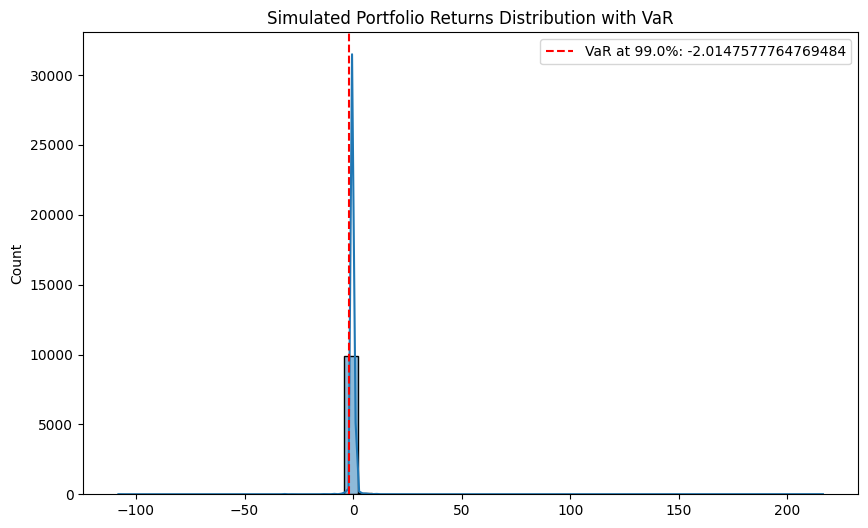

In [103]:
fund_data = simulate_fund_data(252)

sheet_names = ["META", "MSFT", "NFLX"]
dataframes = [get_sheet_data(name) for name in sheet_names]

weights = np.array([0.2, 0.2, 0.2, 0.4])

VaR = calculate_VaR_with_Copula_and_Fund(dataframes, fund_data, weights)

Summary

To Do：

Update Test Data such as 2023 -> 2024

Need use different Machine Learning / Deep Learning /Reniforcement Learning

Annealing

Comment and Text compelte

Scenario quantify

More Data

EVT